In [281]:
# AP Model Training
#This notebook is used to preprocess data, train, and evaluate the AP classification model.

In [282]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report, accuracy_score, log_loss

In [283]:
file_path = r'C:\dev\Research\Data Frame\csv-data\merged_data_fix1.csv'
data = pd.read_csv(file_path)

# Quick overview of the data
data.head()

,filename,gender,age,Normal/Disorder,heigth_AP,width_AP,L1a_1c_AP,L1a_1r_AP,L1a_2c_AP,L1a_2r_AP,...,L5b_2r_LA,S1a_1c_LA,S1a_1r_LA,S1a_2c_LA,S1a_2r_LA,L1b_d_LA,L2b_d_LA,L3b_d_LA,L4b_d_LA,L5b_d_LA
0,0001-F-037Y,F,37,0,2147,1823,876.2222,167.0618,1111.472,168.7665,...,1474.216,483.4817,1624.151,681.5828,1508.435,0,0,0,0,0
1,0003-F-013Y,F,13,0,2428,1996,995.1376,915.0048,1188.762,877.8941,...,1126.033,551.5165,1240.550,704.9568,1149.355,0,0,0,0,0
2,0004-F-010Y,F,10,0,2428,1996,1030.5450,262.7610,1235.536,255.3068,...,1141.984,849.9302,1289.932,937.3315,1150.672,0,0,0,0,0
3,0005-F-025Y,F,25,0,2428,1960,1065.6940,352.9687,1266.615,324.4597,...,1265.159,1116.0610,1411.361,1255.0260,1281.082,0,0,0,0,0
4,0006-F-031Y,F,31,0,2428,1848,856.3824,263.6143,1077.760,224.2906,...,1552.956,1148.7650,1672.106,1234.4680,1571.705,0,0,0,0,0


In [284]:
# Remove unnecessary columns
X = data.drop(columns=['filename', 'gender', 'age', 'Normal/Disorder', 
                       'S1a_1c_LA', 'S1a_1r_LA', 'S1a_2c_LA', 'S1a_2r_LA'])

# แยกฟีเจอร์ที่เกี่ยวข้องกับ AP
X_ap_features = [col for col in data.columns if '_AP' in col]
X_ap = data[X_ap_features]

# Quick overview of the data
X_ap.head()

output_csv = 'filtered_ap_features.csv'  # กำหนดชื่อไฟล์ output
X_ap.to_csv(output_csv, index=False)
print(f"บันทึกข้อมูลเป็นไฟล์ CSV: {output_csv}")

บันทึกข้อมูลเป็นไฟล์ CSV: filtered_ap_features.csv


In [285]:
# เป้าหมาย AP
y_ap = data[['L1b_d_AP', 'L2b_d_AP', 'L3b_d_AP', 'L4b_d_AP', 'L5b_d_AP']]



In [286]:
# ฟังก์ชันสำหรับกรองเป้าหมาย
def filter_targets(y, valid_targets=[0, 1, 2, 3, 4]):
    return y.apply(lambda col: col.where(col.isin(valid_targets))).dropna()

# กรองเป้าหมาย AP
y_ap_filtered = filter_targets(y_ap)
X_filtered_ap = X_ap.loc[y_ap_filtered.index]

In [287]:
# Split data
X_train_ap, X_test_ap, y_train_ap, y_test_ap = train_test_split(
    X_filtered_ap, y_ap_filtered, test_size=0.2, random_state=42
)

# Scaling features
scaler_ap = StandardScaler()
X_train_ap = scaler_ap.fit_transform(X_train_ap)
X_test_ap = scaler_ap.transform(X_test_ap)

In [288]:
# โมเดล MLP
mlp_ap = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)
multi_target_mlp_ap = MultiOutputClassifier(mlp_ap)
multi_target_mlp_ap.fit(X_train_ap, y_train_ap)

MultiOutputClassifier(estimator=MLPClassifier(hidden_layer_sizes=(100, 50),
                                              max_iter=300, random_state=42))

In [289]:
# Save the model
folder_name = 'ap-model'
os.makedirs(folder_name, exist_ok=True)
model_filename = os.path.join(folder_name, 'mlp_ap_model.pkl')
joblib.dump(multi_target_mlp_ap, model_filename)
print(f"โมเดลถูกบันทึกเป็นไฟล์ในโฟลเดอร์: {model_filename}")

โมเดลถูกบันทึกเป็นไฟล์ในโฟลเดอร์: ap-model\mlp_ap_model.pkl


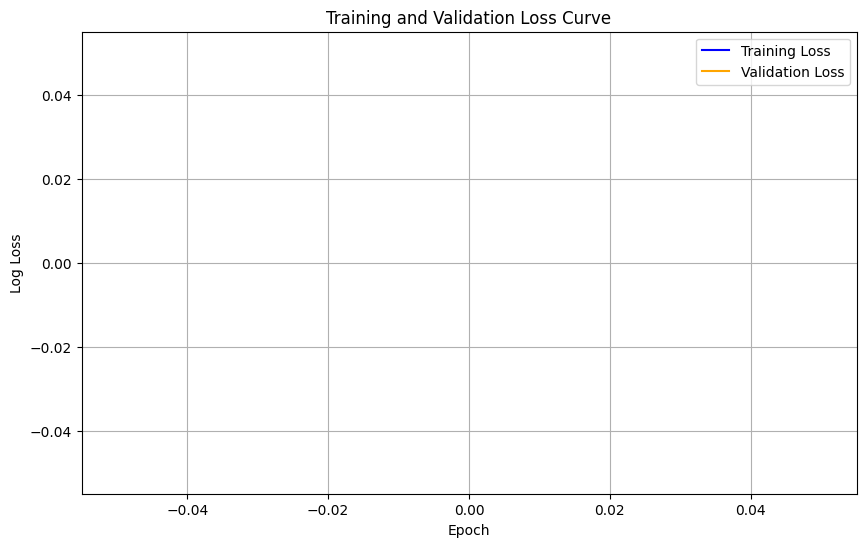

In [290]:
# Plot training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='orange')
plt.title("Training and Validation Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.legend()
plt.grid()
plt.show()

In [291]:
# Predict และ Evaluate
y_pred_ap = multi_target_mlp_ap.predict(X_test_ap)

print("Classification Reports for Filtered AP Targets:")
for i, column in enumerate(y_ap_filtered.columns):
    print(f"\nTarget: {column}")
    print(classification_report(y_test_ap.iloc[:, i], y_pred_ap[:, i]))

Classification Reports for Filtered AP Targets:

Target: L1b_d_AP
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1061
           2       1.00      1.00      1.00         1

    accuracy                           1.00      1062
   macro avg       1.00      1.00      1.00      1062
weighted avg       1.00      1.00      1.00      1062


Target: L2b_d_AP
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1054
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5

    accuracy                           1.00      1062
   macro avg       1.00      1.00      1.00      1062
weighted avg       1.00      1.00      1.00      1062


Target: L3b_d_AP
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1043
           1       1.00      0.80      0.89        10
           2       0.90    

In [292]:
    # Overall Classification Report สำหรับ AP
y_ap_true_flat = y_test_ap.values.flatten()
y_ap_pred_flat = y_pred_ap.flatten()
print("\nOverall Filtered AP Classification Report:")
print(classification_report(y_ap_true_flat, y_ap_pred_flat, zero_division=1))

overall_accuracy_ap = sum(accuracy_score(y_test_ap.iloc[:, i], y_pred_ap[:, i]) for i in range(y_ap_filtered.shape[1])) / y_ap_filtered.shape[1]
print(f"\nOverall Filtered AP Accuracy Across All Targets: {overall_accuracy_ap}")


Overall Filtered AP Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5266
           1       0.94      0.85      0.89        20
           2       0.92      0.96      0.94        24

    accuracy                           1.00      5310
   macro avg       0.95      0.94      0.94      5310
weighted avg       1.00      1.00      1.00      5310


Overall Filtered AP Accuracy Across All Targets: 0.9992467043314501


In [293]:
# Overall Classification Report สำหรับ AP
y_ap_true_flat = y_test_ap.values.flatten()
y_ap_pred_flat = y_pred_ap.flatten()
print("\nOverall Filtered AP Classification Report:")
print(classification_report(y_ap_true_flat, y_ap_pred_flat, zero_division=1))

overall_accuracy_ap = sum(accuracy_score(y_test_ap.iloc[:, i], y_pred_ap[:, i]) for i in range(y_ap_filtered.shape[1])) / y_ap_filtered.shape[1]
print(f"\nOverall Filtered AP Accuracy Across All Targets: {overall_accuracy_ap}")


Overall Filtered AP Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5266
           1       0.94      0.85      0.89        20
           2       0.92      0.96      0.94        24

    accuracy                           1.00      5310
   macro avg       0.95      0.94      0.94      5310
weighted avg       1.00      1.00      1.00      5310


Overall Filtered AP Accuracy Across All Targets: 0.9992467043314501
